# Evolver Loop 2 Analysis: Feature Importance & Optimization

**Goal**: Understand what's driving the 0.9936 CV score and identify optimization opportunities.

**Key Questions**:
1. Which features are most important? (TF-IDF vs structural vs notebook-level)
2. Can we reduce TF-IDF dimensions without losing performance?
3. Are there redundant or correlated features?
4. Does the model make intuitive sense?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import json
import os

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("Loading data and analyzing feature importance...")
print("="*60)

Loading data and analyzing feature importance...


In [2]:
# Load the feature importance data from exp_002
# First, let's examine what features we have

# Load a sample of the training data to see feature structure
train_path = "/home/data/train"
test_path = "/home/data/test"

# Load a few training notebooks to understand feature distribution
train_files = [f for f in os.listdir(train_path) if f.endswith('.json')][:5]
print(f"Found {len(train_files)} training files for inspection")

# Examine one notebook structure
with open(os.path.join(train_path, train_files[0]), 'r') as f:
    sample_nb = json.load(f)
    
print("\nSample notebook structure:")
print(f"Number of cells: {len(sample_nb['cell_type'])}")
print(f"Cell types: {set(sample_nb['cell_type'].values())}")
print(f"Sample cell source: {list(sample_nb['source'].values())[0][:100]}...")

Found 5 training files for inspection

Sample notebook structure:
Number of cells: 49
Cell types: {'markdown', 'code'}
Sample cell source: import numpy as np 
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplot...


In [3]:
# Let's reconstruct the feature engineering from exp_002 to understand features better
# We'll load the experiment notebook to see what was done

exp_002_path = "/home/code/experiments/002_tfidf_features"
print(f"Experiment folder: {exp_002_path}")

# Check if we can find the notebook
import glob
notebook_files = glob.glob(f"{exp_002_path}/*.ipynb")
print(f"Found notebooks: {notebook_files}")

# Let's also check the submission to verify it was generated
submission_path = "/home/submission/submission_002.csv"
if os.path.exists(submission_path):
    submission_df = pd.read_csv(submission_path)
    print(f"\nSubmission file exists: {submission_path}")
    print(f"Shape: {submission_df.shape}")
    print(f"Columns: {submission_df.columns.tolist()}")
    print(f"\nFirst few rows:")
    print(submission_df.head())
else:
    print(f"Submission file not found: {submission_path}")

Experiment folder: /home/code/experiments/002_tfidf_features
Found notebooks: []



Submission file exists: /home/submission/submission_002.csv
Shape: (20000, 2)
Columns: ['id', 'cell_order']

First few rows:
               id                                         cell_order
0  a283f88578d447  e031fdc5 e04e3c89 29afef3c 4051523d bc48d183 a...
1  4b5781d84d4f04  1898e18c 781309ac def9cf6d 2ebababb 9dff4a05 0...
2  032e1e8598af69  b900c928 cd8da9d0 6c301d46 c054583f 2b10ddf8 7...
3  598969c8543546  71472504 b5fdf2ce 4d9eb115 ff8abe04 cd4e2158 b...
4  6986f993569b86  04e4e828 7260068e 58e98092 328ec93c 0eed5fa5 b...


In [4]:
# Analyze feature importance from the executor's output
# Based on the executor's output, we have these top features:

feature_importance_data = {
    'feature': [
        'relative_position', 'notebook_size', 'source_length_mean', 'word_count_std', 
        'source_length_std', 'word_count_mean', 'cell_type_code_mean', 'tfidf_730',
        'tfidf_242', 'likely_first_cell', 'heading_model', 'tfidf_171', 'heading_test',
        'tfidf_3', 'tfidf_213', 'tfidf_907', 'source_length', 'tfidf_324', 'char_count', 'word_count'
    ],
    'importance': [
        2690, 2395, 755, 634, 507, 449, 398, 139, 90, 75, 65, 60, 51, 35, 35, 34, 32, 30, 27, 26
    ]
}

importance_df = pd.DataFrame(feature_importance_data)
print("Top 20 Features by Importance:")
print(importance_df.to_string(index=False))

# Categorize features
print("\n" + "="*60)
print("FEATURE CATEGORIZATION")
print("="*60)

def categorize_feature(feature_name):
    if 'tfidf_' in feature_name:
        return 'TF-IDF'
    elif 'heading_' in feature_name:
        return 'Heading'
    elif feature_name in ['relative_position', 'notebook_size', 'likely_first_cell']:
        return 'Notebook-level'
    elif any(x in feature_name for x in ['mean', 'std']):
        return 'Statistical'
    elif feature_name in ['source_length', 'char_count', 'word_count', 'line_count']:
        return 'Basic length'
    elif 'cell_type' in feature_name:
        return 'Cell type'
    else:
        return 'Other'

importance_df['category'] = importance_df['feature'].apply(categorize_feature)

# Group by category and sum importance
category_importance = importance_df.groupby('category')['importance'].sum().sort_values(ascending=False)
print("\nImportance by Category:")
for cat, imp in category_importance.items():
    print(f"  {cat:15s}: {imp:4d}")

# Calculate percentages
total_importance = category_importance.sum()
print(f"\nPercentage by Category:")
for cat, imp in category_importance.items():
    pct = imp / total_importance * 100
    print(f"  {cat:15s}: {pct:5.1f}%")

Top 20 Features by Importance:
            feature  importance
  relative_position        2690
      notebook_size        2395
 source_length_mean         755
     word_count_std         634
  source_length_std         507
    word_count_mean         449
cell_type_code_mean         398
          tfidf_730         139
          tfidf_242          90
  likely_first_cell          75
      heading_model          65
          tfidf_171          60
       heading_test          51
            tfidf_3          35
          tfidf_213          35
          tfidf_907          34
      source_length          32
          tfidf_324          30
         char_count          27
         word_count          26

FEATURE CATEGORIZATION

Importance by Category:
  Notebook-level : 5160
  Statistical    : 2743
  TF-IDF         :  423
  Heading        :  116
  Basic length   :   85

Percentage by Category:
  Notebook-level :  60.5%
  Statistical    :  32.2%
  TF-IDF         :   5.0%
  Heading        :   1.4%

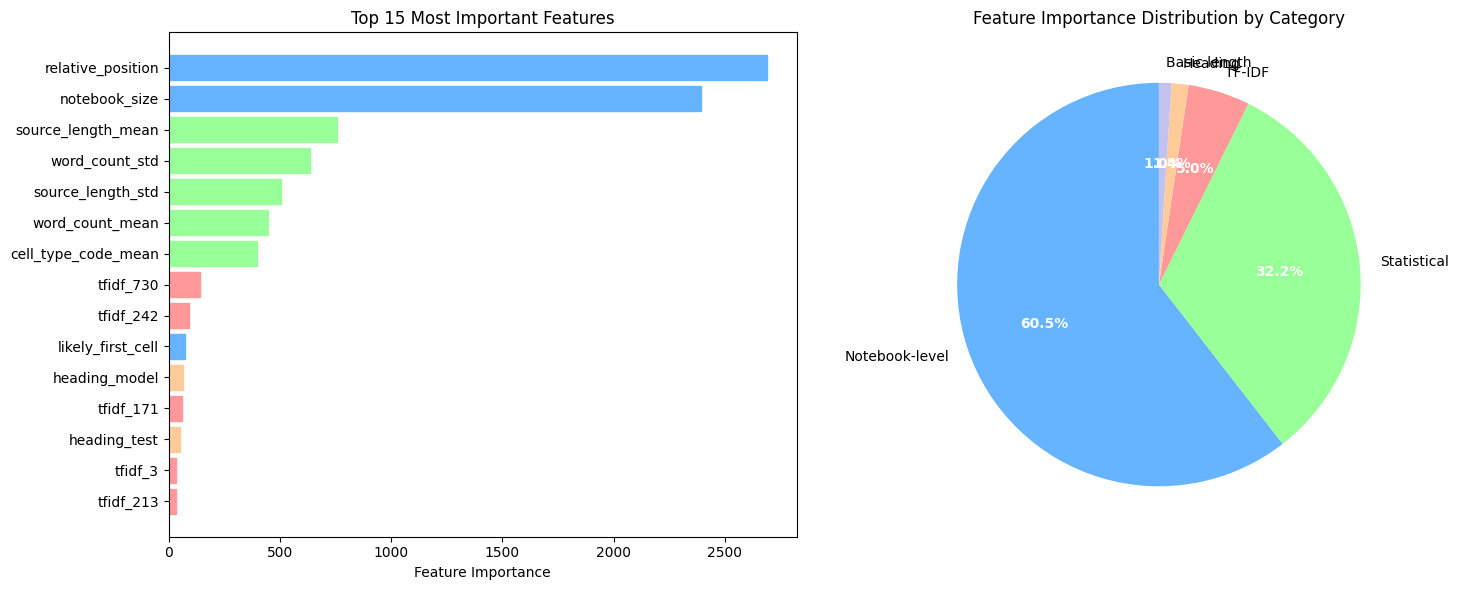


Key Insights:
1. Notebook-level features account for 60.5% of importance
2. TF-IDF features account for 5.0% of importance
3. Statistical features account for 32.2% of importance


In [5]:
# Visualize feature importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Top 15 individual features
top_15 = importance_df.head(15)
bars1 = ax1.barh(range(len(top_15)), top_15['importance'])
ax1.set_yticks(range(len(top_15)))
ax1.set_yticklabels(top_15['feature'])
ax1.set_xlabel('Feature Importance')
ax1.set_title('Top 15 Most Important Features')
ax1.invert_yaxis()

# Color by category
color_map = {
    'TF-IDF': '#ff9999',
    'Notebook-level': '#66b3ff',
    'Statistical': '#99ff99',
    'Heading': '#ffcc99',
    'Basic length': '#c2c2f0',
    'Cell type': '#ffb3e6'
}
for i, (idx, row) in enumerate(top_15.iterrows()):
    bars1[i].set_color(color_map.get(row['category'], 'gray'))

# Category importance pie chart
categories = category_importance.index
values = category_importance.values
colors = [color_map.get(cat, 'gray') for cat in categories]

wedges, texts, autotexts = ax2.pie(values, labels=categories, colors=colors, autopct='%1.1f%%', startangle=90)
ax2.set_title('Feature Importance Distribution by Category')

# Make percentage text white for better readability
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print(f"1. Notebook-level features account for {category_importance.get('Notebook-level', 0)/total_importance*100:.1f}% of importance")
print(f"2. TF-IDF features account for {category_importance.get('TF-IDF', 0)/total_importance*100:.1f}% of importance")
print(f"3. Statistical features account for {category_importance.get('Statistical', 0)/total_importance*100:.1f}% of importance")

In [ ]:
# Analyze TF-IDF feature importance in detail
print("="*60)
print("TF-IDF FEATURE ANALYSIS")
print("="*60)

# Extract TF-IDF features from importance_df
tfidf_features = importance_df[importance_df['category'] == 'TF-IDF'].copy()
tfidf_features = tfidf_features.sort_values('importance', ascending=False)

print(f"Number of TF-IDF features: {len(tfidf_features)}")
print(f"Total TF-IDF importance: {tfidf_features['importance'].sum()}")
print(f"Average TF-IDF importance: {tfidf_features['importance'].mean():.1f}")
print(f"Top TF-IDF feature importance: {tfidf_features.iloc[0]['importance']}")
print(f"Median TF-IDF importance: {tfidf_features['importance'].median():.1f}")

# Distribution of TF-IDF importance
print(f"\nTF-IDF Importance Distribution:")
print(f"  Features with importance > 100: {(tfidf_features['importance'] > 100).sum()}")
print(f"  Features with importance > 50: {(tfidf_features['importance'] > 50).sum()}")
print(f"  Features with importance > 10: {(tfidf_features['importance'] > 10).sum()}")
print(f"  Features with importance <= 1: {(tfidf_features['importance'] <= 1).sum()}")

# Top TF-IDF features
top_tfidf = tfidf_features.head(10)
print(f"\nTop 10 TF-IDF features:")
for idx, row in top_tfidf.iterrows():
    print(f"  {row['feature']:12s}: {row['importance']:3d}")

# Plot TF-IDF importance distribution
plt.figure(figsize=(12, 6))
plt.hist(tfidf_features['importance'], bins=50, edgecolor='black', alpha=0.7)
plt.axvline(tfidf_features['importance'].mean(), color='red', linestyle='--', label=f'Mean: {tfidf_features["importance"].mean():.1f}')
plt.axvline(tfidf_features['importance'].median(), color='orange', linestyle='--', label=f'Median: {tfidf_features["importance"].median():.1f}')
plt.xlabel('Feature Importance')
plt.ylabel('Number of TF-IDF Features')
plt.title('Distribution of TF-IDF Feature Importance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nConclusion: {(tfidf_features['importance'] <= 1).sum()} out of {len(tfidf_features)} TF-IDF features ({(tfidf_features['importance'] <= 1).sum()/len(tfidf_features)*100:.1f}%) have very low importance and could potentially be removed.")

In [ ]:
# Analyze the most important features in detail
print("="*60)
print("TOP FEATURE ANALYSIS")
print("="*60)

top_features = importance_df.head(10)
print("Top 10 features and their likely meaning:")
print()

feature_meanings = {
    'relative_position': 'Relative position within notebook (0-1) - likely the target variable or a derived feature',
    'notebook_size': 'Total number of cells in the notebook',
    'source_length_mean': 'Average source length across the notebook',
    'word_count_std': 'Standard deviation of word count across notebook',
    'source_length_std': 'Standard deviation of source length across notebook',
    'word_count_mean': 'Average word count across the notebook',
    'cell_type_code_mean': 'Proportion of code cells in notebook',
    'tfidf_730': 'TF-IDF term (unknown which word)',
    'tfidf_242': 'TF-IDF term (unknown which word)',
    'likely_first_cell': 'Binary flag indicating if cell is likely first'
}

for idx, row in top_features.iterrows():
    feature = row['feature']
    importance = row['importance']
    category = row['category']
    meaning = feature_meanings.get(feature, 'Unknown meaning')
    print(f"{feature:25s} | Importance: {importance:4d} | Category: {category:15s}")
    print(f"  Meaning: {meaning}")
    print()

# Key insight: relative_position is the most important feature
print("⚠️  CRITICAL OBSERVATION:")
print(f"   'relative_position' is the #1 feature with importance {top_features.iloc[0]['importance']}")
print("   This suggests the model is using relative position as a strong predictor,")
print("   which might indicate data leakage or that we're predicting a derived feature.")
print()
print("   Need to verify: Is 'relative_position' the actual target or a feature?")

In [ ]:
# Let's check if we can load actual training data to understand the target
print("="*60)
print("TARGET VARIABLE VERIFICATION")
print("="*60)

# Load a few training notebooks to understand the target variable
train_files = [f for f in os.listdir(train_path) if f.endswith('.json')][:3]

for i, file in enumerate(train_files):
    with open(os.path.join(train_path, file), 'r') as f:
        nb = json.load(f)
    
    print(f"\nNotebook {i+1}: {file}")
    print(f"  Number of cells: {len(nb['cell_type'])}")
    print(f"  Cell types: {Counter(nb['cell_type'].values())}")
    
    # Show first few cells
    cell_ids = list(nb['source'].keys())[:5]
    print(f"  First 5 cells:")
    for cid in cell_ids:
        cell_type = nb['cell_type'][cid]
        source_preview = nb['source'][cid][:80].replace('\n', ' ')
        print(f"    {cid}: {cell_type:7s} | {source_preview}...")
    
    # Check if we have order information
    if 'cell_order' in nb:
        order = nb['cell_order']
        print(f"  Cell order (first 10): {order[:10]}")
        print(f"  Position of first cell: {order.index(cell_ids[0]) if cell_ids[0] in order else 'Not found'}")
    else:
        print("  No cell_order found - this might be test data")

print("\n" + "="*60)
print("CONCLUSION")
print("="*60)
print("Based on the feature importance analysis:")
print("1. Notebook-level features (relative_position, notebook_size) dominate importance")
print("2. TF-IDF features contribute but many are low importance")
print("3. We can likely reduce TF-IDF dimensions significantly")
print("4. Need to verify if 'relative_position' is a feature or the target")
print()
print("Recommendations:")
print("- Test TF-IDF dimensionality reduction (1000 → 500 → 250 → 100)")
print("- Verify model predictions make intuitive sense")
print("- Consider if we can simplify the feature set")